# video summary at [https://youtu.be/tSUWc-lefRk]()

* I made it as clear as possible and its only **ten minutes**.
* I would love it if you watched it.
* It will probably help break up the monotony of reading cover letters :)
* heres a qr to the video incase this is printed.

![qr vid](notebook_images/qr-vid.png)

### code is hosted on github
* github at [github.com/boppe003/scripps_demo](https://github.com/boppe003/scripps_demo)
* data at [search.earthdata.nasa.gov/projects?projectId=5396249562](https://search.earthdata.nasa.gov/projects?projectId=5396249562)

 ![qr to github](notebook_images/qr_git.png)

#### making plots
* climatology
* standard deviation
* peak value plots

#### testing relationship between variables
* wind speed vs phytoplankton carbon counts
* chlorophyll vs phytoplankton carbon counts

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import xarray as xr
import numpy as np
import scipy.stats as stats

### downloading data

The data products were downloaded from NASA's [earthdata search](https://search.earthdata.nasa.gov/search)
* a project file linked [here](https://search.earthdata.nasa.gov/projects?projectId=5396249562) allows one to redownload the same products

|product title|variables|bounding|
|-------|---------|--------|
|OCI Level-2 Data BGC|chlor_a, poc, carbon_phyto|  spatial: 8.5° N, 135.5° E x 4.0° N, 130.5° E, temporal: 2024-03-05 - 2024-12-31
|NOAA CYGNSS Level 2 Science Wind Speed Product (v1.2)|wind_speed, wind_speed_uncertainty|  spatial: 8.5° N, 135.5° E x 4.0° N, 130.5° E, temporal: 2024-03-05 - 2024-12-31

![image_of_project_page](notebook_images/earthdata_project_photo.png)

### regridding
* There's a lot of documentation on regridding. I feel its out of the scope of the demo.
* see/run `preprocess_cygnss_wind.py` and `preprocess_ogc_bgc.py` to learn a bit more

In [2]:
wind_ds = xr.open_mfdataset('data/CYGNSS_NOAA_L2_SWSP_25KM_V1.2_1.2-20250124_000751/regridded/*.nc', concat_dim='time', combine='nested')
wind_ds = wind_ds.sel(time=slice("2024-03-05", "2024-12-31"))
ocean_ds = xr.open_mfdataset("data/PACE_OCI_L2_BGC_NRT_2.0-20250121_161459/regridded/*.nc")
ocean_ds = ocean_ds.sel(time=slice('2024-03-05', '2024-12-31'))
ocean_ds

<xarray.Dataset> Size: 3GB
Dimensions:           (time: 436, latitude: 577, longitude: 466)
Coordinates:
  * time              (time) datetime64[ns] 3kB 2024-03-05T03:15:38 ... 2024-...
  * latitude          (latitude) float32 2kB 4.0 4.008 4.016 ... 8.489 8.496
  * longitude         (longitude) float32 2kB 130.5 130.5 130.5 ... 135.5 135.5
Data variables:
    chlor_a           (time, latitude, longitude) float32 469MB dask.array<chunksize=(1, 577, 466), meta=np.ndarray>
    carbon_phyto      (time, latitude, longitude) float32 469MB dask.array<chunksize=(1, 577, 466), meta=np.ndarray>
    poc               (time, latitude, longitude) float32 469MB dask.array<chunksize=(1, 577, 466), meta=np.ndarray>
    chlor_a_unc       (time, latitude, longitude) float32 469MB dask.array<chunksize=(1, 577, 466), meta=np.ndarray>
    carbon_phyto_unc  (time, latitude, longitude) float32 469MB dask.array<chunksize=(1, 577, 466), meta=np.ndarray>
    l2_flags          (time, latitude, longitude) float64 938MB dask.array<chunksize=(1, 577, 466), meta=np.ndarray>
Attributes: (12/49)
    gringpointlongitude:               [134.1184  157.78966 154.57634 129.85384]
    gringpointlatitude:                [-3.013308   2.0194993 19.889526  14.7...
    gringpointsequence:                [1 2 3 4]
    title:                             OCI Level-2 Data BGC
    product_name:                      PACE_OCI.20240305T031538.L2.OC_BGC.V2_...
    processing_version:                2.0
    ...                                ...
    geospatial_lon_min:                129.85384
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     1.0164802074432373
    regrid_method:                     bilinear

### variable Climatology for 2024
* mean value per 2024

In [3]:
def plot_everything(ds: xr.Dataset, plot_vars: list, title_desc: str):

    fig, ax = plt.subplots(figsize= (14, 4), ncols=len(plot_vars))

    for n, var in enumerate(plot_vars):
        ds[var].plot(ax=ax[n])
        ax[n].set_title(var + "\n" + title_desc)
    fig.tight_layout()

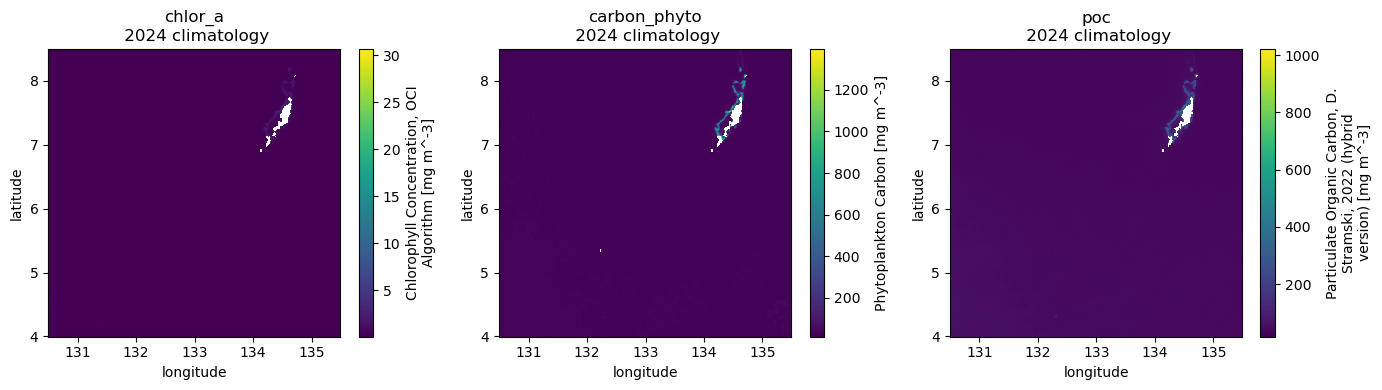

In [4]:
ocean_climatology = ocean_ds.resample(time='YE').mean()
plot_vars = ['chlor_a', 'carbon_phyto', 'poc']


plot_everything(ocean_climatology, plot_vars, " 2024 climatology")
del ocean_climatology

### standard devation for each value
* standard deviation graphed for a given cell over an entire time period

/home/tinkpad/miniconda3/envs/scripps/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


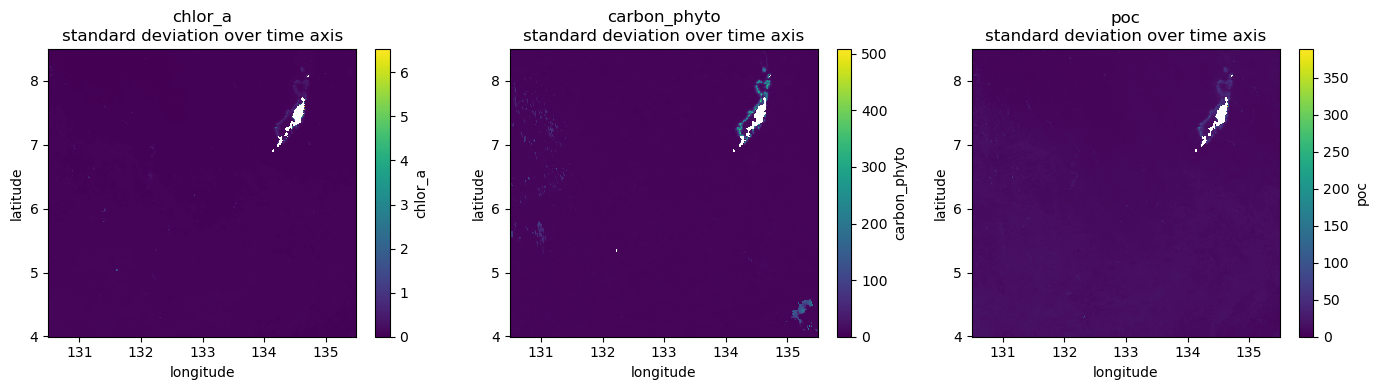

In [5]:
std_dev = ocean_ds.std(dim="time")

plot_everything(std_dev, plot_vars, "standard deviation over time axis")
del std_dev

### max for each value
* max over entire time period graphed for a given cell

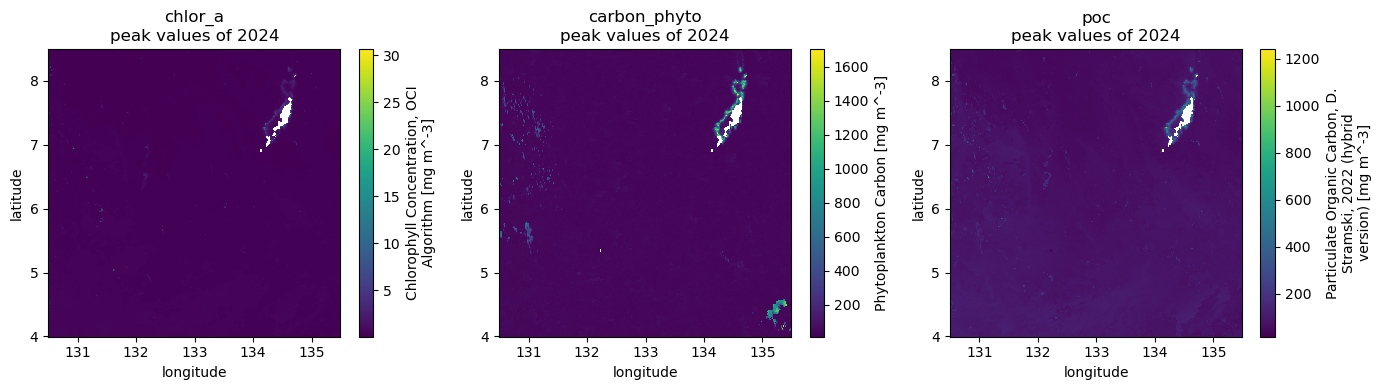

In [6]:
max_values = ocean_ds.resample(time='YE').max()

plot_everything(max_values, plot_vars, "peak values of 2024")
del max_values

### animations
* this is done with a normal python script so there is less overhead. this is the code.
* hastily done without for loops because its not the center of the project

In [ ]:
variable_vbar_bounds = {
    'chlor_a':(0, 5),
    'carbon_phyto':(0, 500),
    'poc':(0, 350)
}
fig, ax = plt.subplots(figsize=(18, 5), ncols=3)

#generates colorbars
for n, variable in enumerate(variable_vbar_bounds):
    vmin, vmax = variable_vbar_bounds[variable]

    ocean_ds[variable].isel(time=0).plot(vmin= vmin, vmax= vmax, ax=ax[n])

def tick_frame(frame):
    for n, variable in enumerate(variable_vbar_bounds):
        vmin, vmax = variable_vbar_bounds[variable]

        ax[n].clear()
        ocean_ds[variable].sel(time= ocean_ds.time[frame]).plot(vmin= vmin, vmax= vmax, ax=ax[n], add_colorbar=False)


ani = animation.FuncAnimation(fig, tick_frame, frames=len(ocean_ds.time), interval=100)

# this bit requires you have ffmpeg installed. it's available through most package managers.
# direct download see, https://ffmpeg.org/ 
ani.save(filename="animation_demo.mp4", writer="ffmpeg") 


## statistics

### rebinning the datasets temporally and spatially

In [7]:
lat_factor, lon_factor = ocean_ds.latitude.size/wind_ds.latitude.size, ocean_ds.longitude.size/wind_ds.longitude.size 
lat_factor, lon_factor = round(lat_factor), round(lon_factor)

# temporal: by day
ocean_ds = ocean_ds.resample(time='D').mean()

binned_wind_ds = wind_ds.resample(time='D').mean()

# # spatial: same size as wind ds.
binned_ocean_ds = ocean_ds.coarsen(latitude=lat_factor, longitude=lon_factor, boundary="trim").mean()
binned_ocean_ds = binned_ocean_ds.reindex_like(binned_wind_ds, method='nearest')



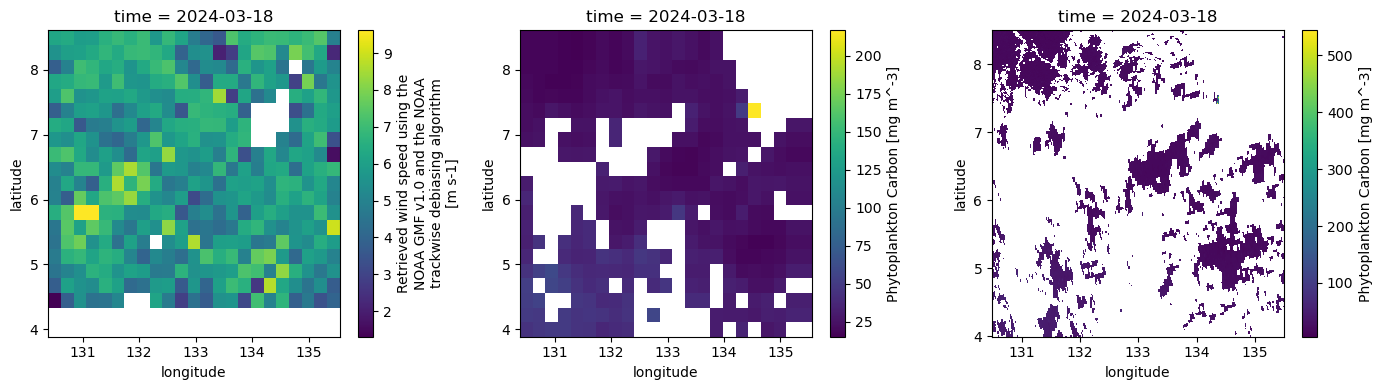

In [8]:

_, ax = plt.subplots(figsize=(14, 4), ncols=3)
n = 13
binned_wind_ds.wind_speed[n].plot(ax=ax[0])
binned_ocean_ds.carbon_phyto[n].plot(ax=ax[1])
ocean_ds.carbon_phyto[n].plot(ax=ax[2])
plt.tight_layout()

### calculating linear regression of point over time, per longitude, latitude bin

In [9]:
def linregress_func(wind_speed, carbon_phyto):
    mask = ~np.isnan(wind_speed) & ~np.isnan(carbon_phyto)
    if mask.sum() < 100:
        return np.nan, np.nan, np.nan, np.nan, np.nan
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(wind_speed[mask], carbon_phyto[mask])
    return slope, intercept, r_value, p_value, std_err


In [10]:
stat_vars = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']
stats_ds = xr.Dataset(
    data_vars = {
        "carbon_phyto": binned_ocean_ds['carbon_phyto'],
        "wind_speed": binned_wind_ds['wind_speed']
    }
)

template_array = np.full((stats_ds.latitude.size, stats_ds.longitude.size), (np.nan), np.float32)

for var in stat_vars:
    stats_ds[var] = (["latitude", "longitude"], template_array.copy())

stats_ds = stats_ds.chunk({'latitude': 10, 'longitude': 10, 'time': -1})

In [11]:

results = xr.apply_ufunc(
    linregress_func,
    stats_ds.wind_speed,
    stats_ds.carbon_phyto,
    input_core_dims=[['time'], ['time']],
    output_core_dims=[[], [], [], [], []],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float, float, float, float, float]
)

stats_ds['slope'], stats_ds['intercept'], stats_ds['r_value'], stats_ds['p_value'], stats_ds['std_err'] = results
stats_ds = stats_ds.compute()
del results

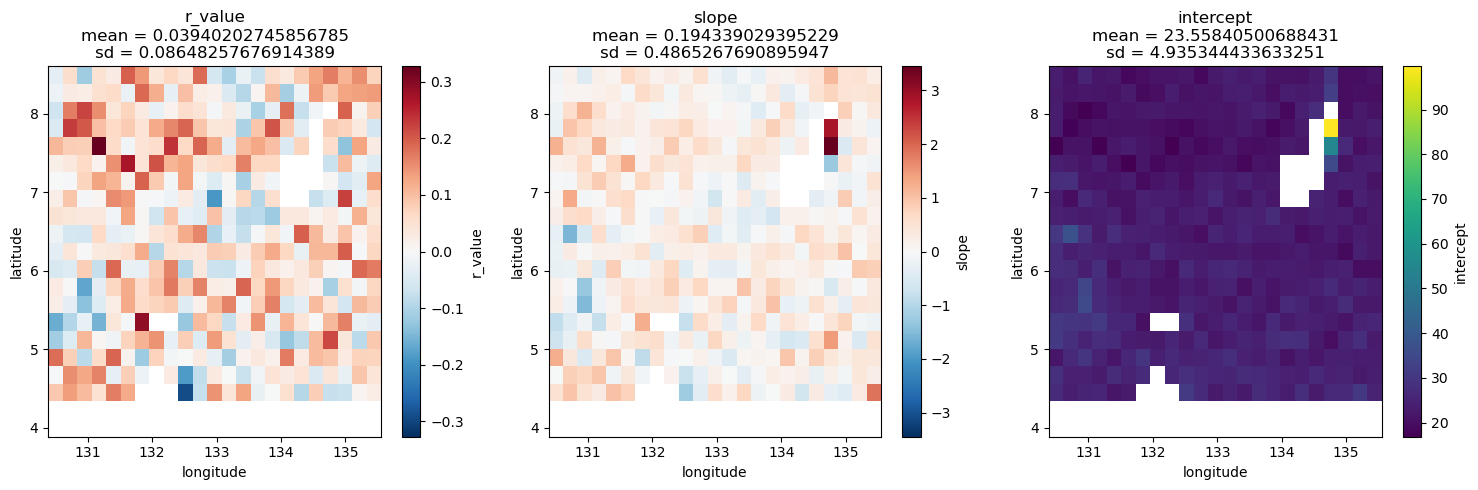

In [12]:
variable_vbar_bounds = {
    'r_value':(None, None),
    'slope':(None, None),
    'intercept':(None, None),
}


n_plots = len(variable_vbar_bounds)
fig, ax = plt.subplots(figsize=(5*n_plots, 5), ncols=n_plots)
for n, var in enumerate(variable_vbar_bounds):
    vmin, vmax = variable_vbar_bounds[var]
    stats_ds[var].plot(ax=ax[n], vmin=vmin, vmax=vmax)
    ax[n].set_title(f"{var}\nmean = {str(stats_ds[var].mean().values)}\nsd = {str(stats_ds[var].std().values)}")

fig.tight_layout() 


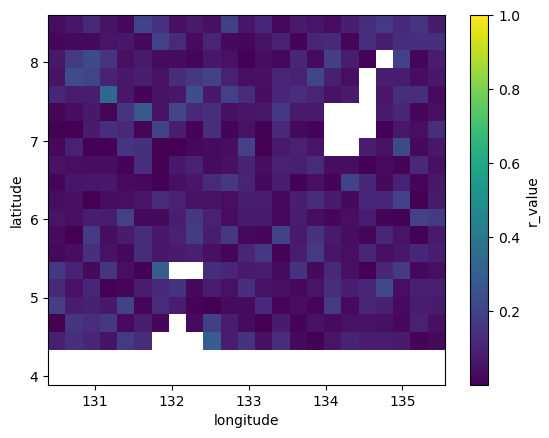

In [13]:
abs(stats_ds['r_value']).plot(vmax=1)

<xarray.DataArray 'r_value' ()> Size: 8B
array(0.03940203)


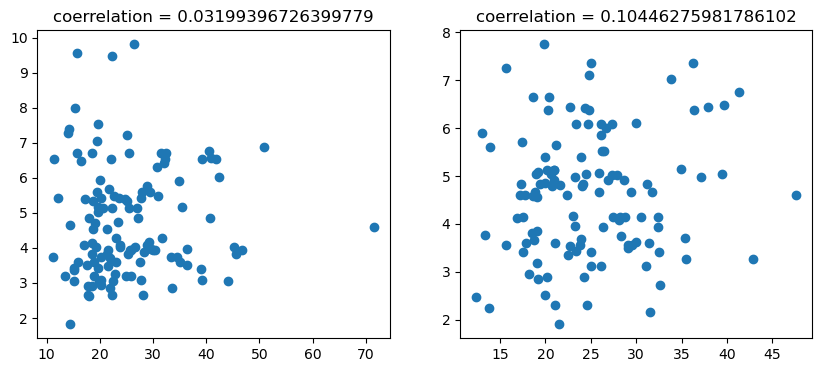

In [14]:
cells_of_interest = []
cells_of_interest.append(stats_ds.isel(latitude=10, longitude=3))
cells_of_interest.append(stats_ds.isel(latitude=7, longitude=18))
n_cells = len(cells_of_interest)
_, ax = plt.subplots(figsize=(5*n_cells, 4), ncols=n_cells)

for n, cell in enumerate(cells_of_interest):
    ax[n].scatter(cell.carbon_phyto, cell.wind_speed)
    ax[n].set_title('coerrelation = '+str(cell.r_value.values))

print(stats_ds.r_value.mean())

In [15]:
stat_vars = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']
stats_ds = xr.Dataset(
    data_vars = {
        "carbon_phyto": binned_ocean_ds['carbon_phyto'],
        "chlor_a": binned_ocean_ds['chlor_a']
    }
)

template_array = np.full((stats_ds.latitude.size, stats_ds.longitude.size), (np.nan), np.float32)

for var in stat_vars:
    stats_ds[var] = (["latitude", "longitude"], template_array.copy())

stats_ds = stats_ds.chunk({'latitude': 10, 'longitude': 10, 'time': -1})

In [16]:

results = xr.apply_ufunc(
    linregress_func,
    stats_ds.chlor_a,
    stats_ds.carbon_phyto,
    input_core_dims=[['time'], ['time']],
    output_core_dims=[[], [], [], [], []],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float, float, float, float, float]
)

stats_ds['slope'], stats_ds['intercept'], stats_ds['r_value'], stats_ds['p_value'], stats_ds['std_err'] = results
stats_ds = stats_ds.compute()
del results

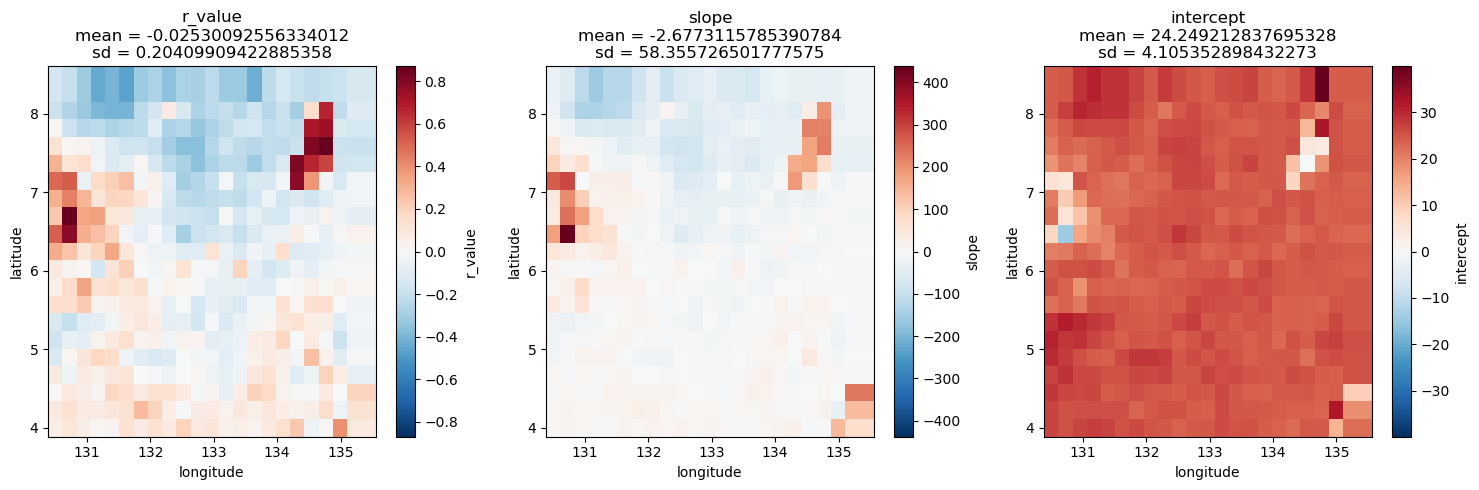

In [17]:
variable_vbar_bounds = {
    'r_value':(None, None),
    'slope':(None, None),
    'intercept':(None, None),
}


n_plots = len(variable_vbar_bounds)
fig, ax = plt.subplots(figsize=(5*n_plots, 5), ncols=n_plots)
for n, var in enumerate(variable_vbar_bounds):
    vmin, vmax = variable_vbar_bounds[var]
    stats_ds[var].plot(ax=ax[n], vmin=vmin, vmax=vmax)
    ax[n].set_title(f"{var}\nmean = {str(stats_ds[var].mean().values)}\nsd = {str(stats_ds[var].std().values)}")

fig.tight_layout() 


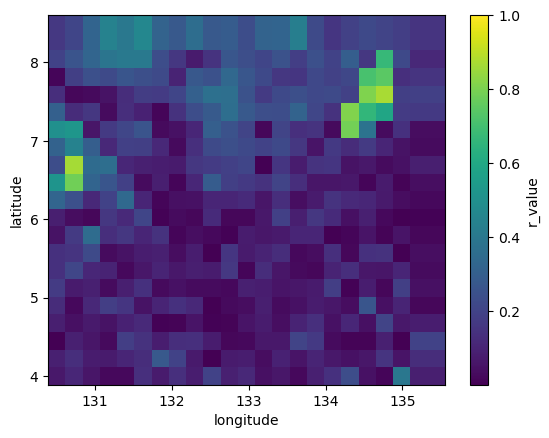

In [18]:
abs(stats_ds['r_value']).plot(vmax=1)

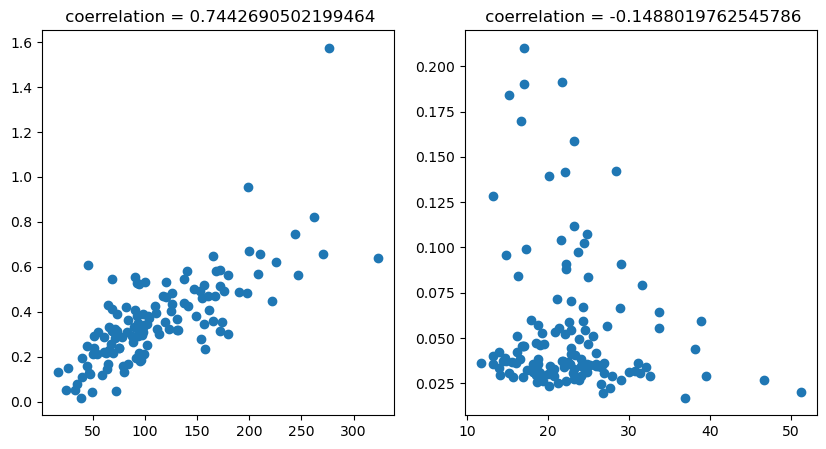

In [19]:
cells_of_interest = []
cells_of_interest.append(stats_ds.isel(latitude=17, longitude=19)) #high val
cells_of_interest.append(stats_ds.isel(latitude=20, longitude=-1)) #low val
n_cells = len(cells_of_interest)
_, ax = plt.subplots(figsize=(5*n_cells, 5), ncols=n_cells)

for n, cell in enumerate(cells_of_interest):
    ax[n].scatter(cell.carbon_phyto, cell.chlor_a)
    ax[n].set_title(' coerrelation = '+str(cell.r_value.values))

### results
* this approach shows significant evidence that in the waters of Palau, there is a relationship between carbon_phytoplankton and chlorophyll counts (obviously)
* it appears to be very regional, likely because there is very little plankton in most of the measurements.

### things to consider about this approach:
* some phenomena are simply just very regional.
* significant amount of the swaths are obscured by cloud cover
* data could be verified by looking at uncertainty values like chlor_a_unc
* data also could be matched with insitu data for calibration
* for less regional phenomena it might be easier to simply plot all the values of two variable against each other, and not separate them spatially.